In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import pickle
import seaborn as sns
import json
import numpy as np
import matplotlib.pylab as plt

In [3]:
from cmcrameri import cm

color_dict = dict(
    {
        True: cm.batlow.colors[90],
        False: cm.batlow.colors[30],
    }
)

#### Load morphological embeddings and morphometrics

In [4]:
df_neurons = pd.read_pickle('../../data/data_tables/df_func_emb.pkl')

In [6]:
df_neurons.loc[df_neurons.depth_vs_basal_mean <= 2, 'basal_bias'] = True
df_neurons.loc[df_neurons.depth_vs_basal_mean > 2, 'basal_bias'] = False

In [7]:
df_neurons.basal_bias.value_counts()

False    2346
True      382
Name: basal_bias, dtype: int64

In [10]:
# Drop duplicate nuclues ids
df_neurons = df_neurons.drop_duplicates('nucleus_id').sort_index()

In [11]:
df_neurons.basal_bias.value_counts()

False    2019
True      328
Name: basal_bias, dtype: int64

#### Run nested cross-validation

In [12]:
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    cross_val_predict,
)
from sklearn.preprocessing import StandardScaler

In [13]:
from sklearn.metrics import r2_score
from scipy import stats

In [14]:
import warnings

warnings.filterwarnings('ignore')

In [17]:
X = np.stack(df_neurons['rweight'].values)
y = np.stack(df_neurons['depth_vs_basal_mean'].values)

In [18]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [19]:
scaler2 = StandardScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1)).reshape(-1)

In [20]:
# Set up possible values of parameters to optimize over
p_grid = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10], 'l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]}

In [21]:
svm = ElasticNet(max_iter=1000)

inner_cv = KFold(n_splits=10, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Nested CV with parameter optimization
clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
nested_score = cross_val_score(clf, X=X_norm, y=y_norm, cv=outer_cv)
y_preds = cross_val_predict(clf, X=X_norm, y=y_norm, cv=outer_cv)
nested_scores = nested_score.mean()

In [22]:
r2_score(y_norm, y_preds)

0.1679886933150413

In [23]:
y_pred_unnorm = scaler2.inverse_transform(y_preds.reshape(-1, 1))

In [24]:
stats.pearsonr(y_norm, y_preds)

PearsonRResult(statistic=0.4112609613423733, pvalue=1.782034420505697e-96)

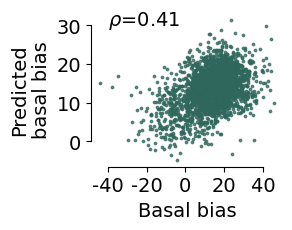

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(y, y_pred_unnorm, color=cm.batlow.colors[75], alpha=0.75, s=3)
ax.set_xlabel('Basal bias', fontsize=14)

ax.set_ylabel('Predicted\nbasal bias', fontsize=14)

ax.annotate(r"$\rho$=0.41", (-40, 30), fontsize=14)
ax.set_yticks([0, 10, 20, 30], [0, 10, 20, 30], fontsize=14)
ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40], fontsize=14)

sns.despine(trim=1)

ax.set_aspect(2)
# plt.savefig('figures/basal_bias_regression.pdf', transparent=True, bbox_inches='tight')